### Laboratiorio 6
### Deep Learning
### Javier Chavez 21016
### Andres Quezada 21085

In [16]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Load and prepare the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Optimized buffer and batch size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [18]:
# Optimized generator with 5x5 kernels and output shape assertions
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

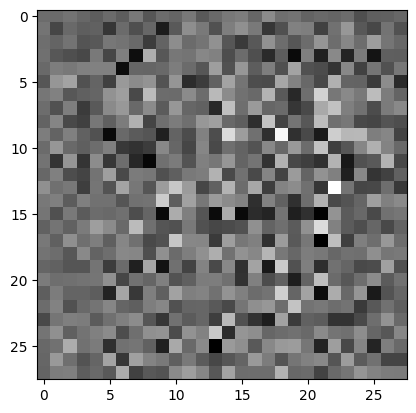

In [19]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [20]:
# Optimized discriminator with 5x5 kernels
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00149304]], shape=(1, 1), dtype=float32)


In [22]:
# Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Loss functions
def generator_loss(fake_out):  # Generator loss function
    return cross_entropy(tf.ones_like(fake_out), fake_out)

def discriminator_loss(real_out, fake_out):  # Discriminator loss function
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    total_loss = real_loss + fake_loss
    return total_loss

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Entrenamiento

In [24]:
# Training loop variables
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed to visualize progress during training (fixed seed)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Checkpoint to save model progress
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [25]:
# Almacenar las pérdidas
gen_losses = []
disc_losses = []

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss  # Devolver las pérdidas

In [26]:
# Generar y guardar las imágenes
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Cambia la ruta para guardar en Google Drive
    plt.savefig('/content/drive/MyDrive/gan_images/output_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [ ]:
# Función que realiza el ciclo de entrenamiento completo
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

            # Convertir los tensores a valores numéricos y almacenarlos
            gen_losses.append(gen_loss.numpy())
            disc_losses.append(disc_loss.numpy())

        # Generar imágenes después de cada epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Guardar el modelo cada 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Mostrar la pérdida en cada epoch
        print(f'Tiempo para la epoch {epoch + 1} es {time.time()-start} segundos')

        # Graficar las pérdidas solo en las épocas 1, 10, 20, 30, 40, y 50
        if epoch + 1 in [1, 10, 20, 30, 40, 50]:
            plt.figure(figsize=(10, 5))
            plt.plot(gen_losses, label='Pérdida del Generador')
            plt.plot(disc_losses, label='Pérdida del Discriminador')
            plt.legend()
            plt.title(f'Pérdidas en la epoch {epoch + 1}')
            plt.xlabel('Iteraciones')
            plt.ylabel('Pérdida')

            # Guardar la gráfica de pérdidas en Google Drive
            plt.savefig(f'/content/drive/MyDrive/gan_images/loss_epoch_{epoch + 1:04d}.png')
            plt.show()

    # Generar imágenes al final del entrenamiento
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Iniciar el entrenamiento
train(train_dataset, EPOCHS)
